## Installing the required libraries

In [45]:
!pip install pandas openpyxl scikit-learn matplotlib yellowbrick

In [46]:
#import all of the required libraries and classes right here

import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

warnings.simplefilter('ignore')

## Data Ingestion

In [47]:
df=pd.read_excel('Coffee Shop data.xlsx')
population=pd.read_csv('population.csv',skiprows=[0])

In [48]:
population.head()

,Geography,Label for GEO_ID,Race/Ethnic Group,Population Groups,Total,Errata of Total,Total!!1-person household,Total!!2-person household,Total!!3-person household,Total!!4-person household,Total!!5-person household,Total!!6-person household,Total!!7-or-more-person household
0,8600000US89010,ZCTA5 89010,1,Total population,172,NaN,51,69,19,12,12,4,5
1,8600000US89019,ZCTA5 89019,1,Total population,1164,NaN,412,421,134,83,57,32,25
2,8600000US89060,ZCTA5 89060,1,Total population,4144,NaN,1106,1714,550,361,222,95,96
3,8600000US89061,ZCTA5 89061,1,Total population,2109,NaN,469,936,283,206,112,62,41
4,8600000US89439,ZCTA5 89439,1,Total population,671,NaN,193,314,88,55,17,2,2


In [49]:
df.head()#checking first five rows

,ID no.,Business Name,Street address,City,State,Zip Code,Phone,Rating,Gender majority,Median Salary,Latte Price
0,1,Brew Haven,8 Old Shore Place,Oakland,California,94616,415-810-4769,4.5,Male,72463,3.31
1,2,Bean Bliss,6650 Clarendon Crossing,Stockton,California,95210,209-701-1665,5.0,Female,87117,5.35
2,3,Caffeine Cove,7281 Buell Road,Fresno,California,93773,559-137-3554,4.7,Male,86394,4.15
3,4,Mug Magic,670 Jackson Avenue,Torrance,California,90510,818-789-5573,4.3,Male,88343,5.34
4,5,Daily Grind,37 Ludington Terrace,San Diego,California,92196,619-354-2389,1.6,Male,77795,3.11


In [50]:
# check for data info
df.info()
#our data types checks out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID no.           1000 non-null   int64  
 1   Business Name    1000 non-null   object 
 2   Street address   1000 non-null   object 
 3   City             1000 non-null   object 
 4   State            1000 non-null   object 
 5   Zip Code         1000 non-null   int64  
 6   Phone            1000 non-null   object 
 7   Rating           1000 non-null   float64
 8   Gender majority  1000 non-null   object 
 9   Median Salary    1000 non-null   int64  
 10  Latte Price      1000 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 86.1+ KB


In [51]:
#check the number of records and features
df.shape

(1000, 11)

In [52]:
population.shape

(1705, 13)

In [53]:
# get basic stats about the data
df.describe()
#see avergae latte price and salary

,ID no.,Zip Code,Rating,Median Salary,Latte Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,92976.163000,3.784600,81102.915000,5.039030
std,288.819436,1706.943177,1.150717,5210.745903,1.153467
min,1.000000,90005.000000,1.000000,72001.000000,3.000000
25%,250.750000,91751.750000,3.200000,76578.000000,4.057500
50%,500.500000,92883.000000,4.240000,81080.000000,5.040000
75%,750.250000,94257.000000,4.580000,85630.000000,6.020000
max,1000.000000,96154.000000,5.000000,89978.000000,6.990000


Text(0.5, 1.0, 'Top 5 cities with most cofee shops')

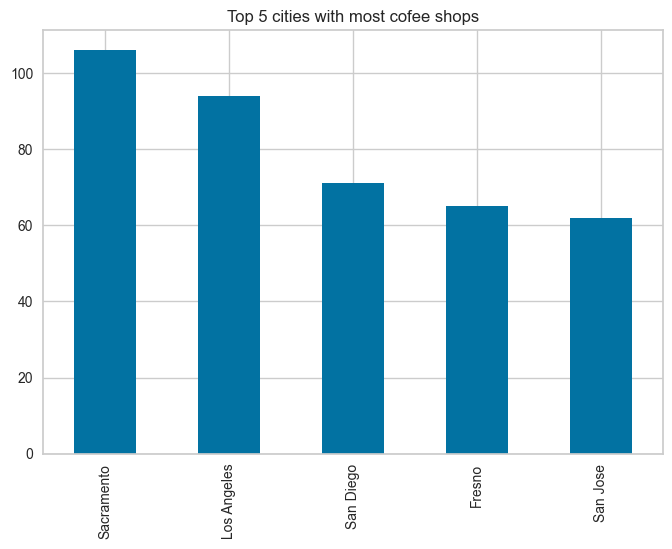

In [54]:
ax=df['City'].value_counts().head(5).plot(kind='bar')
ax.set_title('Top 5 cities with most cofee shops')

Text(0.5, 1.0, 'Top 10 most famous brands')

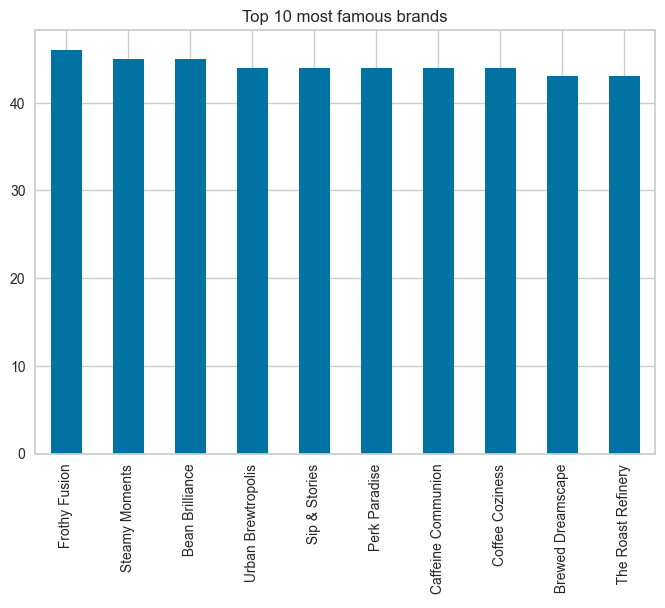

In [55]:
ax=df['Business Name'].value_counts().head(10).plot(kind='bar')
ax.set_title('Top 10 most famous brands')

## Data Preprocessing

In [56]:
df.isna().sum()
# no null values

ID no.             0
Business Name      0
Street address     0
City               0
State              0
Zip Code           0
Phone              0
Rating             0
Gender majority    0
Median Salary      0
Latte Price        0
dtype: int64

In [57]:
#converting zipcode to object data (str)
df['Zip Code']=df['Zip Code'].astype(str)

In [58]:
#extract zip code from population
def find_zip_code(geocode):
    pattern = r'\d{5}$'

    match = re.search(pattern, geocode)

    if match:
        zip_code = match.group(0)
    return zip_code
        

In [59]:
population['Zip Code']=population['Geography'].apply(find_zip_code)

In [60]:
cafe_data=df.copy()
# merging the population via zip code as population is an important feature to determing the price / locations
df=pd.merge(cafe_data,population)
#notice that the data size is reduced afer a join

In [61]:
#keeping only Total from population
columns=cafe_data.columns.values.tolist()+['Total']
df=df[columns]
#rename Total to Population
df=df.rename(columns={"Total":"Population"})

In [62]:
#keeping only relevant features
df=df[['Zip Code','Rating','Median Salary','Latte Price','Population']]
df.shape

(412, 5)

## Feature Engineering

In [63]:
df['income_per_captia']=df['Median Salary']/df['Population'
                                               ]#compute income per captia

In [64]:
X_cluster=df
ms = StandardScaler()

X_cluster = ms.fit_transform(X_cluster)

## Model Selection and Hyperparameter Tuning

1. Determine optimal number of clusters KMeans

In [65]:
#run PCA to reduce dimenisons

from sklearn.decomposition import PCA
pca=PCA(2,random_state=101)
X_cluster_pca=pca.fit_transform(X_cluster)

In [66]:
inertia = []
for n in range(2 , 10):
    algorithm = (KMeans(n_clusters = n ) )
    algorithm.fit(X_cluster_pca)
    inertia.append(algorithm.inertia_)

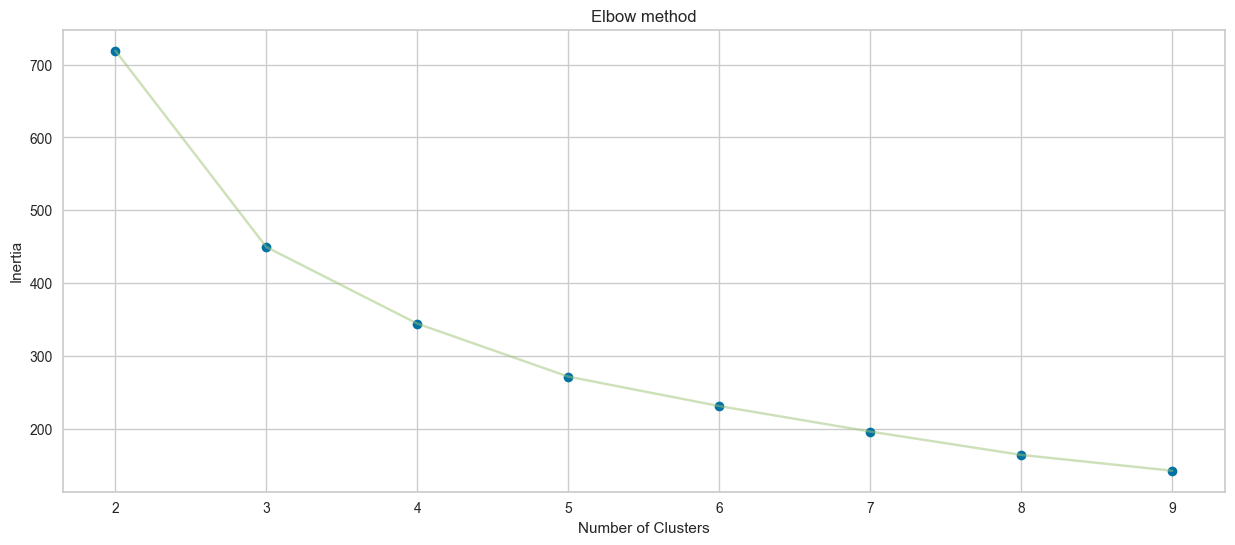

In [67]:

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(2 , 10) , inertia , 'o')
plt.plot(np.arange(2 , 10) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.title('Elbow method',loc='center')
plt.show()

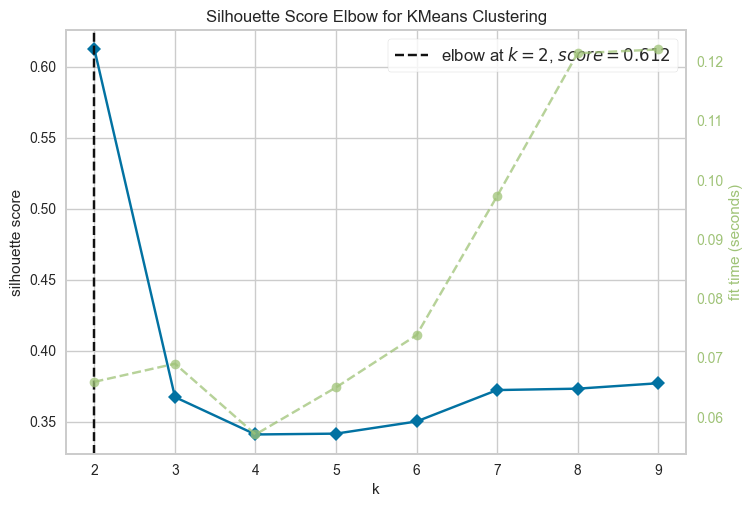

In [68]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_cluster_pca)
visualizer.show()
plt.show()

The optimal number is 2

In [69]:
kmeans = KMeans(n_clusters = 2 ,random_state=101).fit(X_cluster_pca)
labels = kmeans.predict(X_cluster_pca)


In [70]:
df['Cluster']=labels#adding labels to the dataset

In [71]:
#plot
centroids = kmeans.cluster_centers_
h = 0.02
x_min, x_max = X_cluster_pca[:, 0].min() - 1, X_cluster_pca[:, 0].max() + 1
y_min, y_max =X_cluster_pca[:, 1].min() - 1, X_cluster_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]) 


In [72]:
X_cluster_pca_df=pd.DataFrame(X_cluster_pca)


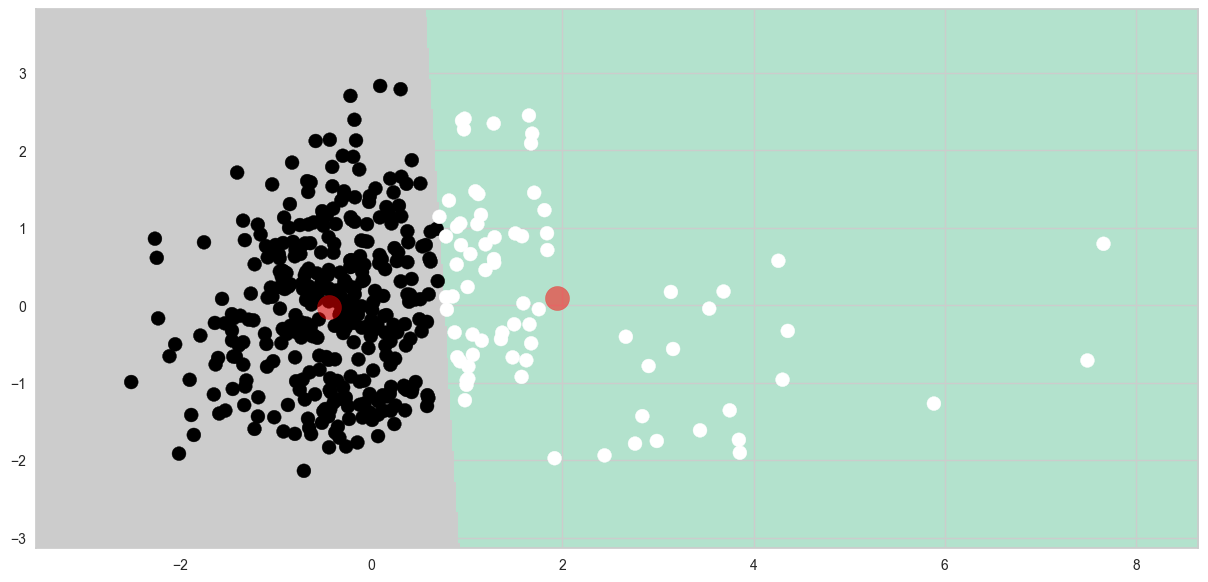

In [73]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
X_cluster_pca=pd
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')


plt.scatter( x = X_cluster_pca_df[0], y = X_cluster_pca_df[1] , c = labels, s = 100)
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.show()

In [74]:
# Find the cluster with the highest potential (e.g., high ratings, high income, low latte price)
top_cluster = df.groupby('Cluster').mean().idxmax().values[0]

# Get the top 5 Zip Codes within the top cluster
top_5_zip_codes = df[df['Cluster'] == top_cluster].nlargest(6, 'Rating')['Zip Code'].values
top_5_zip_codes=np.unique(top_5_zip_codes)
print("Top 5 Zip Codes for your coffee shop:")
print(top_5_zip_codes)

Top 5 Zip Codes for your coffee shop:
['90005' '92505' '93726' '93907' '95210']


2. DBScan

In [75]:
DBS_clustering = DBSCAN().fit_predict(X_cluster_pca_df)
df['Cluster DBScan']=DBS_clustering

In [76]:

df['Cluster DBScan'].value_counts()

 0    379
-1     26
 1      7
Name: Cluster DBScan, dtype: int64

K means has better silhouette_score

In [77]:
print("silhouette_score score dbscan",round(silhouette_score(X_cluster_pca_df, DBS_clustering),2))
print("silhouette_score score kmeans",round(silhouette_score(X_cluster_pca_df, labels),2))
print('Higher score means better results')

silhouette_score score dbscan 0.39
silhouette_score score kmeans 0.43
Higher score means better results


## Prepare the dataset for regression



In [78]:
#remove zip code as we are having zip code clusters
#remove the validation set from data

X=df.drop(['Zip Code','Latte Price','Cluster DBScan'],axis=1)
# apply scaling
y=df['Latte Price']



In [79]:
#divide  data into train and test split
X_train, X_val, y_train, y_val = train_test_split(
X, y, test_size=0.20, random_state=101)

#

## Linear Regression with GridSearchCV

In [80]:
# Linear Regression GridSearchCV
linear_params = {
    'fit_intercept': [True, False]
}
linear_model = LinearRegression()
linear_grid_search = GridSearchCV(linear_model, param_grid=linear_params, cv=5, scoring='neg_mean_squared_error',                       return_train_score=True,
)
linear_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [81]:
print("LR:Best parameters are ",linear_grid_search.best_params_)
print("LR:Best score is  ",linear_grid_search.best_score_)


LR:Best parameters are  {'fit_intercept': True}
LR:Best score is   -1.3936602886447977


## Random Forest Regression with GridSearchCV

In [82]:
# Random Forest Regression GridSearchCV
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=101)
rf_grid_search = GridSearchCV(rf_model, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=101),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [83]:
print("RF:Best parameters are ",rf_grid_search.best_params_)
print("RF:Best score is  ",rf_grid_search.best_score_)


RF:Best parameters are  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
RF:Best score is   -1.4967981028640458


## Fitiing on best parameters

In [84]:
#refit on best paramaters
lr=LinearRegression(**linear_grid_search.best_params_)
lr.fit(X_train, y_train)

LinearRegression()

In [85]:
rf_best=rf_grid_search.best_params_#getting best params
rf_best['random_state']=101
rf=RandomForestRegressor(**rf_best)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                      random_state=101)

In [86]:
#evalaute on test set
# Calculating all 3 predictions 
pred_by_lr =  lr.predict(X_val)
pred_by_rf= rf.predict(X_val)


# printing RMSE for all 3 techniques
print(f'LR RMSE: {round(np.sqrt(mse(y_val,pred_by_lr)),2)}')
print(f'RF RMSE: {round(np.sqrt(mse(y_val,pred_by_rf)),2)}')




LR RMSE: 1.14
RF RMSE: 1.23


In [87]:
#preidct prices for new branches
result = df[df['Zip Code'].isin(top_5_zip_codes)].groupby('Zip Code').apply(lambda x: x.head(1)).reset_index(drop=True)#pic one from each
zip_codes=result['Zip Code']
result=result[['Rating','Median Salary','Population','income_per_captia','Cluster']]
# lr performed better
#put back zip code
result['Latte Price']=lr.predict(result)
result['Zip Code']=zip_codes
result[['Zip Code','Latte Price']].round(2)

,Zip Code,Latte Price
0,90005,5.12
1,92505,5.07
2,93726,5.10
3,93907,5.03
4,95210,5.04
